In [1]:
from keras.layers import Dense,Input
from keras.losses import *
from keras.optimizers import *
from keras.models import Model
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from statsmodels.regression.quantile_regression import QuantReg

In [3]:
%matplotlib inline

In [4]:
times = []
accel = []
with open('mcycle.tsv', 'r') as f:
  lines = f.readlines()
  lines = lines[1:]
  for line in lines:
    values = line.split("\t")
    times.append(float(values[0]))
    accel.append(float(values[1]))

x = np.asarray(times)
y = np.asarray(accel)


scaler = StandardScaler()
scaler.fit(x.reshape(x.shape[0],1))
x = scaler.transform(x.reshape(x.shape[0],1))

scaler.fit(y.reshape(y.shape[0],1))
y = scaler.transform(y.reshape(y.shape[0],1))

In [5]:
def new(input_shape1, quantile_list):
  c1 = Dense(units = 10,activation="softplus",kernel_initializer='he_normal')(input_shape1)
  c2 = Dense(units = 7,activation="softplus",kernel_initializer='he_normal')(c1)
  
  c_mean = Dense(units = 1,kernel_initializer='he_normal')(c2)
  c3 = Dense(units = len(quantile_list),kernel_initializer='he_normal')(c2)
  model = Model(input = [input_shape1], output = [c_mean,c3])
  return model


def quantile_loss(all_qs,y_true,y_pred):

    penalty_factor = 1  #penalisation coefficient 
    
    e = y_true - y_pred
    delta = y_pred[:,1:] - y_pred[:,:-1]
    #delta = tf.roll(y_pred[:,1:], shift=-1, axis = 0) - y_pred[:,1:]
    delta = delta[:-1]
    total_loss = K.mean(K.maximum(all_qs*e, (all_qs-1)*e), axis=-1) + penalty_factor * K.mean(K.maximum(0.0,-1.0 * delta))
    return total_loss

In [9]:
Q = np.array([0.1,0.9])
model  = new(Input((1,)),Q)

opt = Adam(lr= 0.01)
model.compile(optimizer = opt , loss=['mse',lambda y,f: quantile_loss(Q,y,f)])

model.fit(x,[y,y],epochs=1000,validation_split= 0.10,batch_size=32)


c:\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


Train on 84 samples, validate on 10 samples
Epoch 1/1000
84/84 [==============================] - 0s 4ms/step - loss: 4.2076 - dense_7_loss: 1.3576 - dense_8_loss: 2.8499 - val_loss: 3.0487 - val_dense_7_loss: 0.1806 - val_dense_8_loss: 2.8682
Epoch 2/1000
84/84 [==============================] - 0s 59us/step - loss: 2.7046 - dense_7_loss: 1.1015 - dense_8_loss: 1.6031 - val_loss: 1.8678 - val_dense_7_loss: 0.0836 - val_dense_8_loss: 1.7843
Epoch 3/1000
84/84 [==============================] - 0s 71us/step - loss: 1.9245 - dense_7_loss: 1.0353 - dense_8_loss: 0.8893 - val_loss: 0.9247 - val_dense_7_loss: 0.0621 - val_dense_8_loss: 0.8627
Epoch 4/1000
84/84 [==============================] - 0s 59us/step - loss: 1.5882 - dense_7_loss: 1.0413 - dense_8_loss: 0.5468 - val_loss: 0.2195 - val_dense_7_loss: 0.0716 - val_dense_8_loss: 0.1480
Epoch 5/1000
84/84 [==============================] - 0s 47us/step - loss: 1.4407 - dense_7_loss: 1.0519 - dense_8_loss: 0.3888 - val_loss: 0.1279 - val_

In [10]:
pred_value,pred_all = model.predict(x)

pred_q10 = pred_all[:,0].reshape(-1,1)
pred_q90 = pred_all[:,1].reshape(-1,1)

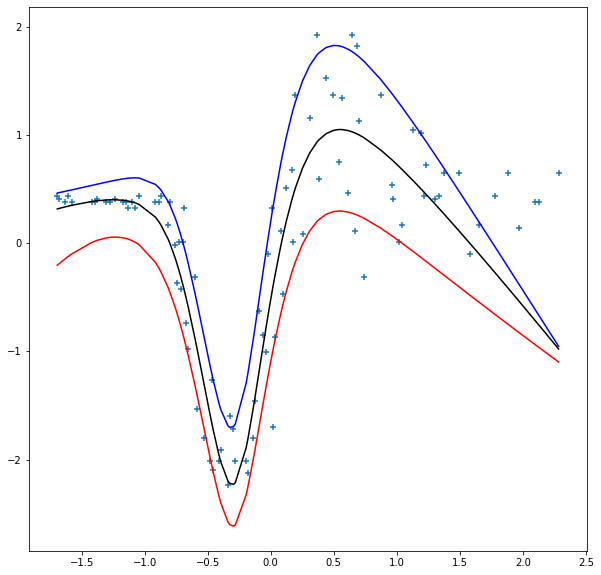

In [11]:
plt.figure(figsize = (10,10))
plt.plot(x,pred_value.reshape(pred_value.shape[0],1),'k')
plt.plot(x,pred_q10.reshape(pred_q10.shape[0],1),'r')
plt.plot(x,pred_q90.reshape(pred_q90.shape[0],1),'b')
plt.scatter(x,y, marker='+')

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

In [17]:
data = sm.datasets.engel.load_pandas().data
mod = smf.quantreg('foodexp ~ income', data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Mon, 13 Jan 2020   No. Observations:                  235
Time:                        22:08:50   Df Residuals:                      233
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


In [18]:
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['income']] + \
            res.conf_int().loc['income'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

ols = smf.ols('foodexp ~ income', data).fit()
ols_ci = ols.conf_int().loc['income'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['income'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

      q           a         b        lb        ub
0  0.05  124.880098  0.343361  0.268632  0.418090
1  0.15  111.693660  0.423708  0.382780  0.464636
2  0.25   95.483539  0.474103  0.439900  0.508306
3  0.35  105.841294  0.488901  0.457759  0.520043
4  0.45   81.083647  0.552428  0.525021  0.579835
5  0.55   89.661370  0.565601  0.540955  0.590247
6  0.65   74.033435  0.604576  0.582169  0.626982
7  0.75   62.396584  0.644014  0.622411  0.665617
8  0.85   52.272216  0.677603  0.657383  0.697823
9  0.95   64.103964  0.709069  0.687831  0.730306
{'a': 147.47538852370573, 'b': 0.48517842367692354, 'lb': 0.4568738130184233, 'ub': 0.5134830343354237}


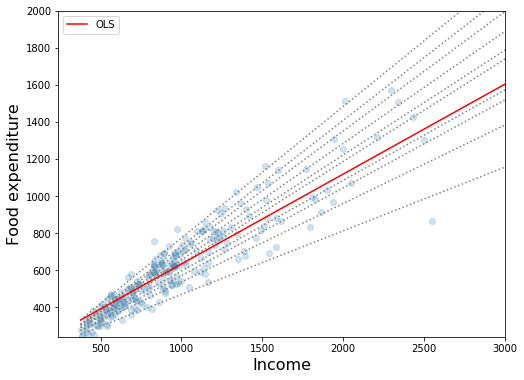

In [19]:

x = np.arange(data.income.min(), data.income.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')

y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(data.income, data.foodexp, alpha=.2)
ax.set_xlim((240, 3000))
ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel('Income', fontsize=16)
ax.set_ylabel('Food expenditure', fontsize=16);

In [20]:
Q = np.array([0.1,0.9])
model  = new(Input((1,)),Q)

opt = Adam(lr= 0.01)
model.compile(optimizer = opt , loss=['mse',lambda y,f: quantile_loss(Q,y,f)])

model.fit(data.income,[data.foodexp,data.foodexp],epochs=1000,validation_split= 0.10,batch_size=32)

c:\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


Train on 211 samples, validate on 24 samples
Epoch 1/1000
211/211 [==============================] - 0s 2ms/step - loss: 346743.1389 - dense_11_loss: 345534.4354 - dense_12_loss: 1208.6969 - val_loss: 138704.0000 - val_dense_11_loss: 137344.8750 - val_dense_12_loss: 1359.1219
Epoch 2/1000
211/211 [==============================] - 0s 38us/step - loss: 62382.1108 - dense_11_loss: 60930.5756 - dense_12_loss: 1451.5354 - val_loss: 14556.4062 - val_dense_11_loss: 13089.5400 - val_dense_12_loss: 1466.8666
Epoch 3/1000
211/211 [==============================] - 0s 43us/step - loss: 26537.0198 - dense_11_loss: 25111.7886 - dense_12_loss: 1425.2306 - val_loss: 16342.0635 - val_dense_11_loss: 15103.9062 - val_dense_12_loss: 1238.1571
Epoch 4/1000
211/211 [==============================] - 0s 42us/step - loss: 41231.4127 - dense_11_loss: 40154.8934 - dense_12_loss: 1076.5195 - val_loss: 8387.1162 - val_dense_11_loss: 7578.6538 - val_dense_12_loss: 808.4625
Epoch 5/1000
211/211 [=================

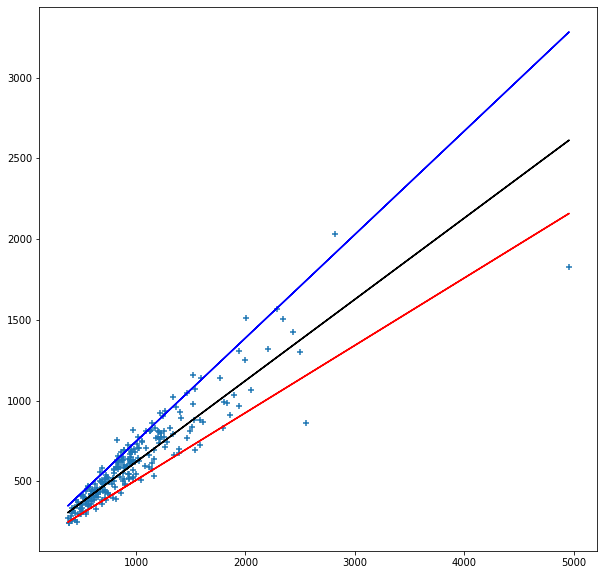

In [21]:
pred_value,pred_all = model.predict(data.income)

pred_q10 = pred_all[:,0].reshape(-1,1)
pred_q90 = pred_all[:,1].reshape(-1,1)

plt.figure(figsize = (10,10))
plt.plot(data.income,pred_value.reshape(pred_value.shape[0],1),'k')
plt.plot(data.income,pred_q10.reshape(pred_q10.shape[0],1),'r')
plt.plot(data.income,pred_q90.reshape(pred_q90.shape[0],1),'b')
plt.scatter(data.income,data.foodexp, marker='+')